In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import h5py
import matplotlib.pyplot as plt
# Check if CUDA (GPU support) is available
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU.")

MPS is available. Using GPU.


In [75]:
# Load and preprocess the data
def load_and_preprocess_data(file_path):
    with h5py.File(file_path, 'r') as h5f:
        images = [h5f[img_name]["hist"][:].T[0:750] for img_name in h5f.keys()]
        npulses = [h5f[img_name].attrs['npulses'] for img_name in h5f.keys()]
    scaler = MinMaxScaler(feature_range=(-1,1))
    for i in range(len(images)):
        images[i] = scaler.fit_transform(images[i])
    return images,npulses,scaler

# Prepare sequences and targets
def create_sequences_and_targets(images,npulses):
    sequences = []
    targets = []
    npulses_targets = []
    for img, puls in zip(images,npulses):
        for i in range(len(img) - seq_length):
            sequences.append(img[i:i + seq_length])
            targets.append(img[i + seq_length])
            npulses_targets.append(puls)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32), torch.tensor(npulses_targets, dtype=torch.float32)

# Dataset and DataLoader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets, npulse_targets):
        self.sequences = sequences
        self.targets = targets
        self.npulse_targets = npulse_targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        return self.sequences[index], self.targets[index], self.npulse_targets[index]

class ModifiedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_prob):
        super(ModifiedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_size+1),  # Existing output
            #nn.Linear(128, 1)  # Additional output for the range 1 to 20
        )
    
    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        output = self.dropout(output)
        output = self.fc_layers(output)
        
        # Apply tanh to the existing output
        existing_output = torch.tanh(output[:, :-1])  # Exclude the new output
        new_output = torch.relu(output[:, -1]).reshape(-1,1)  # New output without tanh
        output = torch.cat([existing_output, new_output], dim=1)
        return output

In [138]:
# Hyperparameters
batch_size = 32
num_epochs = 200
learning_rate = 0.00003
input_size = 750
hidden_size = 128
output_size = 750
seq_length = 8  # Number of previous rows to consider


In [139]:
# Load and preprocess data
data_file = '../lstm_data2_simdata.h5'  # Replace with the actual path to your HDF5 file
images,npulses, scaler = load_and_preprocess_data(data_file)

# # Create sequences and targets
sequences, targets, pulse_targets = create_sequences_and_targets(images,npulses)


In [133]:
# # Create DataLoader
dataset = CustomDataset(sequences, targets, pulse_targets)
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size)# // 2
#test_size = len(dataset) - train_size - val_size
#train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Initialize the model
model = ModifiedLSTMModel(input_size, hidden_size, output_size, num_layers=1, dropout_prob=.3)
model.to(device)
# # Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [134]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

#Initialize variables for early stopping
best_train_loss = 10000
patience = 10  # Number of epochs without improvement to wait before stopping
min_loss_change = 0.001  # Half a percent change threshold
early_stopping_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_sequences, batch_targets, batch_pulses in train_dataloader:
        batch_sequences, batch_targets, batch_pulses = batch_sequences.to(device), batch_targets.to(device), batch_pulses.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_sequences)
        
        # Split the outputs into existing outputs and the new output
        outputs_existing = outputs[:, :-1]  # Exclude the last column (new output)
        output_new = outputs[:, -1]  # Extract the last column (new output)

        # Calculate loss for the existing outputs (with tanh)
        loss_existing = criterion(outputs_existing, batch_targets)

        # Calculate loss for the new output (no tanh)
        loss_new = criterion(output_new, batch_pulses)

        # Combine the losses
        loss = loss_existing + loss_new*750
        
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    loss_change = (best_train_loss-train_loss)/best_train_loss
    # Check if training loss has improved
    print(loss_change)
    if loss_change >= min_loss_change:
        best_train_loss = train_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Check if early stopping criteria are met
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered. Best training loss: {best_train_loss}")
        break
        
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for batch_sequences, batch_targets, batch_pulses in val_dataloader:
            batch_sequences, batch_targets, batch_pulses = batch_sequences.to(device), batch_targets.to(device), batch_pulses.to(device)
            outputs = model(batch_sequences)
            # Split the outputs into existing outputs and the new output
            outputs_existing = outputs[:, :-1]  # Exclude the last column (new output)
            output_new = outputs[:, -1]  # Extract the last column (new output)

            # Calculate loss for the existing outputs (with tanh)
            loss_existing = criterion(outputs_existing, batch_targets)

            # Calculate loss for the new output (no tanh)
            loss_new = criterion(output_new, batch_pulses)

            # Combine the losses
            loss = loss_existing + loss_new

            total_val_loss += loss.item()
        
        val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    final_num_epochs = epoch
print("Training finished!")


0.999273359141536
Epoch [1/300], Train Loss: 0.7266, Val Loss: 0.2138
0.7197554610974186
Epoch [2/300], Train Loss: 0.2036, Val Loss: 0.1183
0.18345422423503507
Epoch [3/300], Train Loss: 0.1663, Val Loss: 0.1378
0.13598934802624904
Epoch [4/300], Train Loss: 0.1437, Val Loss: 0.1319
0.07288859667726147
Epoch [5/300], Train Loss: 0.1332, Val Loss: 0.2095
0.06733187356933215
Epoch [6/300], Train Loss: 0.1242, Val Loss: 0.1993
0.05342816850200368
Epoch [7/300], Train Loss: 0.1176, Val Loss: 0.1748
0.03677097801603451
Epoch [8/300], Train Loss: 0.1133, Val Loss: 0.1963
0.0349413874480037
Epoch [9/300], Train Loss: 0.1093, Val Loss: 0.2657
0.05355557311669511
Epoch [10/300], Train Loss: 0.1035, Val Loss: 0.2381
0.043556931762457236
Epoch [11/300], Train Loss: 0.0989, Val Loss: 0.2450
0.03665447422922921
Epoch [12/300], Train Loss: 0.0953, Val Loss: 0.2699
0.03613536661507433
Epoch [13/300], Train Loss: 0.0919, Val Loss: 0.1986
0.03589762563602311
Epoch [14/300], Train Loss: 0.0886, Val Los

Epoch [111/300], Train Loss: 0.0543, Val Loss: 0.0805
-0.004867609995346468
Epoch [112/300], Train Loss: 0.0545, Val Loss: 0.0799
-0.0025379272460520847
Epoch [113/300], Train Loss: 0.0544, Val Loss: 0.0829
-0.001997377441260792
Epoch [114/300], Train Loss: 0.0544, Val Loss: 0.0822
-0.010890798646790247
Epoch [115/300], Train Loss: 0.0549, Val Loss: 0.0840
0.002174447590984379
Epoch [116/300], Train Loss: 0.0541, Val Loss: 0.0821
-0.0097267238303698
Epoch [117/300], Train Loss: 0.0547, Val Loss: 0.0822
-0.012827579930036827
Epoch [118/300], Train Loss: 0.0548, Val Loss: 0.0818
-0.010547151727568758
Epoch [119/300], Train Loss: 0.0547, Val Loss: 0.0780
-0.011603716779422757
Epoch [120/300], Train Loss: 0.0548, Val Loss: 0.0819
0.0007626527911718126
Epoch [121/300], Train Loss: 0.0541, Val Loss: 0.0839
-0.02103718341134403
Epoch [122/300], Train Loss: 0.0553, Val Loss: 0.0809
-0.011496084113067807
Epoch [123/300], Train Loss: 0.0548, Val Loss: 0.0902
-0.0011211510712150514
Epoch [124/300

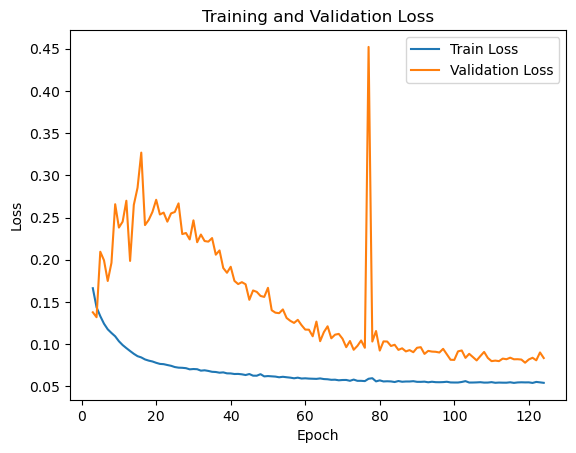

In [135]:
# Plotting training and validation losses
plt.plot(range(3, final_num_epochs + 1), train_losses[2:final_num_epochs], label='Train Loss')
plt.plot(range(3, final_num_epochs + 1), val_losses[2:final_num_epochs], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'lstm_npulses_model.pth')

torch.Size([8, 2048])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])
torch.Size([1, 2049])
torch.Size([1, 2049])
tensor([0.])


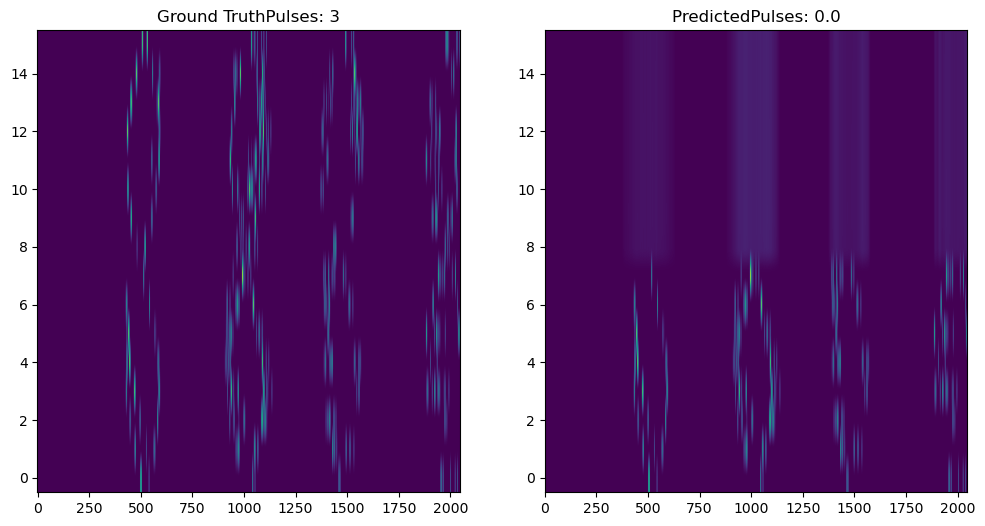

In [137]:
# Load the trained model
model = ModifiedLSTMModel(input_size, hidden_size, output_size,num_layers=1, dropout_prob=0)
model.to(device)
model.load_state_dict(torch.load('lstm_npulses_model.pth'))
model.eval()

new_images = images  

new_example_image_normalized= new_images[100]
examples_pulses = npulses[100]

# Take the first 8 rows from the new example image
initial_input = torch.tensor(new_example_image_normalized[:8], dtype=torch.float32)
initial_input_full = torch.tensor(new_example_image_normalized, dtype=torch.float32)
# Predict the remaining 8 rows using the LSTM model
npulses_list = []
with torch.no_grad():
    predicted_rows = initial_input.clone()
    print(predicted_rows.shape)
    for i in range(seq_length, 16):
        input_seq = predicted_rows[i - seq_length:i].unsqueeze(0)  # Add a batch dimension
        input_seq = input_seq.to(device)
        predicted_row = model(input_seq)
        print(predicted_row.shape)
        predicted_row = predicted_row.to('cpu')
        print(predicted_row.shape)
        predicted_rows = torch.cat((predicted_rows, predicted_row[:,:-1]), dim=0)
        print(predicted_row[:,-1])
        npulses_list.append(predicted_row[:,-1][0])
avg_pulses = np.mean(np.array(npulses_list))        
# Plot the ground truth and predicted images side by side
def plot_images_side_by_side(ground_truth, predicted):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(ground_truth, cmap='viridis', origin='lower', aspect='auto')
    axes[0].set_title(f'Ground Truth' + f'Pulses: {examples_pulses}')
    axes[1].imshow(predicted, origin='lower', aspect='auto', cmap='viridis')
    axes[1].set_title(f'Predicted' + f'Pulses: {avg_pulses}')

    plt.show
    
# Plot the images
ground_truth = initial_input_full
predicted_image = predicted_rows.detach().numpy()

plot_images_side_by_side(ground_truth, predicted_image)



